<a href="https://colab.research.google.com/github/fatima-bukhari5/liveness_detection_colab/blob/main/Liveness_VGG16_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Imports

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
import keras
import itertools
import pandas as pd
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.models import Model
from keras.layers.core import Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from imutils import paths
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Importing Data Sets

In [ ]:
INIT_LR = 0.0001
BS = 10
EPOCHS = 8

In [ ]:
# Paths for the images
train_path = '/content/real_and_fake/train'
valid_path = '/content/real_and_fake/valid'
test_path = '/content/real_and_fake/test'

In [ ]:
def read_image_data(X,Y):
    '''
    The following function is to convert the data into numpy array through `data_processing` function and 
    resize it according vgg16 input size of 224 by 224

    Parameters:
    X => df['Image paths'] (dataframe column of image paths)
    Y => df['Labels'] (dataframe column of image labels)

    Returns `data` in the form of numpy array and labels as encoded.
    '''
    
    data =[]
    labels = Y
    for path in X:
        image = cv2.imread(path)
        image = cv2.resize(image,(224,224))
        data.append(image)
    data, labels = data_processing(data, labels)
    
    print('[INFO] Converting Data into Image form and encoding labels')
    return data, labels

In [ ]:
def data_organization(img_path):
    '''
    This function is to organize the data in the form of data frames to have clear understanding 
    and readability of data w.r.t to its labels

    Parameters: 
    img_path = folder path of images base folder as string

    Returns: dataframe with organized image paths and their labels
    '''
    print("Getting labels for images...")
    data = []
    labels = []
    list_image_path = []
    folders_list = os.listdir(img_path)
    
    # loop over all folders at a time. i.e real and fake
    for folder in folders_list:
        
        # extract the class label from the filename to add into the df
    
        folder_path = os.path.join(img_path,folder)
        images_list = os.listdir(folder_path)
        for image_name in images_list:
            label = folder
            imagePath = os.path.join(folder_path,image_name)
            labels.append(label)
            list_image_path.append(imagePath)
            
    image_path_label = {'image_path': list_image_path,'labels':labels}
    df_image_path_label = pd.DataFrame(image_path_label)
    
    print("DataFrame Complete....")
    return df_image_path_label

In [ ]:
def data_processing(data,labels):
    '''
    Data processing to convert images data to numpy along with label encoding
    
    Parameters:
    data -> list of images data
    labels -> list of labels
    
    returns:
    data, labels as numpy array of image data and encoded labels
    '''
    data = np.array(data, dtype="float")
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, 2)
    
    return data, labels

## Build Fine-tuned VGG16 model

VGG16 Model was used in an ImageNet competition where thousands of images were classified into different categories. We'll be using this model as a baseline and fine tune it as to our specific requirements. 
VGG16 in itself is a model that classifies images into a number of classes that are not limited to just two. In our case the output layer requires just two nodes representing two classes as `real` and `fake`. So, we will be tuning the model accordingly. 
<br>
<br>

Importing the model will take time as its a file of size almost 17 MB 

In [ ]:
def model_training(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - using vgg16 model layers as base layers for the new model.
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing VGG16 ")
    vgg16_model = keras.applications.vgg16.VGG16(include_top=True)
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in vgg16_model.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=EPOCHS)
    
    return model

In [ ]:
def get_predictions(model, df_testing):
    '''
    Getting predictions w.r.t to the trained model as passed and the training data
    
    Parameters:
    model: trained model
    df_testing: data for testing in the form of dataframe
    
    Returns:
    
    Predictions as 0 or 1 and true_labels after data processing
    '''
    
    # getting test data in numpy 
    test_data, true_labels = read_image_data(df_testing['image_path'], df_testing['labels']) 
    
    # gettin predictions against the model
    print('[INFO] Getting Predictions')
    predictions = model.predict(test_data, steps=1, verbose=0)
    predictions_rounded = np.round(predictions)
    
    return predictions_rounded, true_labels

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def model_performance(predictions, true_labels):
    '''
    The model displays a confusion matrix using a previously built confusion matrix function taken from sklearn.
    
    Parameters:
    predictions: previous predictions
    true_labels: array of actual labels to be compared
    
    Result: dislay confusion matrix
    '''
    print('[INFO] Getting Confusion Matrix')
    cm = confusion_matrix(true_labels[:,0], predictions[:,0])
    

    cm_plot_labels = ['real','fake']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    

In [ ]:
def main():
    '''
    calling all functions
    '''
    
    # getting labels to each data set
    df_training = data_organization(train_path)
    df_validation = data_organization(valid_path)
    df_testing = data_organization(test_path)
    
    # getting train and validation data in numpy 
    train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'])
    val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'])
    
    # get the trained model
    model = model_training(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
    
    # get the results
    predictions, true_labels = get_predictions(model = model, df_testing=df_testing)
    
    #
    model_performance(predictions=predictions, true_labels=true_labels)

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing VGG16 
553476096/553467096 [==============================] - 3s 0us/step
[INFO] compiling model...
[INFO] training network for 8 epochs...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
16/16 [==============================] - 17s 291ms/step - loss: 0.9411 - accuracy: 0.5515 - val_loss: 0.7071 - val_accuracy: 0.6444
Epoch 2/8
16/16 [==============================] - 2s 150ms/step - loss: 0.8005 - accuracy: 0.5818 - val_loss: 0.6011 - val_accuracy: 0.7778
Epoch 3/8
16/16 [==============================] - 2s 149ms/step - loss: 0.6905 - accuracy: 0.6606 - val_loss: 0.4851 - val_accuracy: 0.8667
Epoch 4/8
16/16 [==============================] - 2s 150ms/step - loss: 0.6860 - accuracy: 0.7030 - val_loss: 0.4100 - val_accuracy: 0.8889
Epoch 5/8
16/16 [==============================] - 3s 153ms/step - loss: 0.6184 - accuracy: 0.7515 - val_loss: 0.3620 - val_accuracy: 0.9556
Epoch 6/8
16/16 [==============================] - 3s 153ms/step - loss: 0.5837 - accuracy: 0.7455 - val_loss: 0.3282 - val_accuracy: 0.9333
Epoch 7/8
16/16 [==============================] - 3s 153ms/step - loss: 0.5260 - accuracy: 0.7515 - val_loss: 0.3043 - val_accuracy: 0.9333
Epoch 8/8
16

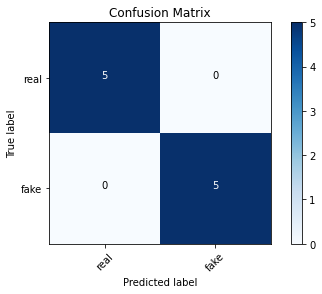

In [ ]:
main()

### Mobile Net

In [ ]:
mobile = keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         